In [1]:
import torch
import torchvision
from torchvision.transforms import transforms
import numpy as np
import os
from PIL import Image
import random

from matplotlib import pyplot as plt




# Initial Setup

In [2]:
batch_size = 4
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose([transforms.ToTensor(),\
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),\
                              transforms.ConvertImageDtype(dtype = torch.float32)])

In [ ]:
train = torchvision.datasets.CIFAR10(root ='./data',train = True, download = True,transform = transform)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
trainloader = torch.utils.data.DataLoader(train,batch_size = batch_size,shuffle= True, num_workers = 0)
os.listdir('./data')

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified


In [ ]:
for i in iter(trainloader):
    print([type(k) for k in i])
    print(i[1],i[0].size())
    print(i[1])
    imgs = i[0]
    img = i[0][0]
    print(img.dtype)
    break



[<class 'torch.Tensor'>, <class 'torch.Tensor'>]
tensor([0, 0, 6, 3]) torch.Size([4, 3, 32, 32])
tensor([0, 0, 6, 3])
torch.float32


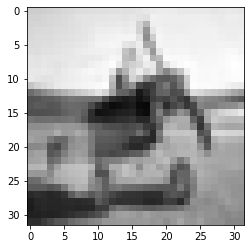

In [ ]:
def imshow(img):
    img = img.to(torch.float32)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(img)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
#         self.type = self.conv1.weight.dtype
        
    def forward(self,x):
#         x = x.type(self.conv1.weight.dtype)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = F.softmax(x,dim = -1 )
        return x

#Create Models

Model1 = MyNN()
Model2 = MyNN().bfloat16()

#Test forward function
y = Model1.forward(imgs)
# torch.sum(y,dim= -1)

In [ ]:
import time

import torch.optim as optim

def training(model,epochs,batch_size,train_set,device):
    #Set Optimisers
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    trainloader = torch.utils.data.DataLoader(train_set,batch_size = batch_size,shuffle= True, num_workers = 0)
    
    time_start = time.perf_counter()
    print('hi')
    for epoch in range(epochs):
        
        running_loss = 0
        for i,data in enumerate(iter(trainloader)):
            images, labels = data[0].to(device),data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    total_time =time.perf_counter()-  time_start 
    
    print(f'Finished Training \nTotal Time {total_time}\n Average Time Per Epoch {(total_time)/epochs}')


In [ ]:
#Save Model
def saveModel(filename):
    PATH = f'./{filename}.pth'
    torch.save(Model1.state_dict(), PATH)
    print(f'{filename}.pth saved!')

In [ ]:

def test(model,testset,device):
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
    correct = 0
    total = 0
    correct_class = {classname: 0 for classname in classes}
    total_class = {classname: 0 for classname in classes}
    
    with torch.no_grad():
        for i,data in enumerate(testloader):
  
            images, labels = data[0].to(device),data[1].to(device)
            outputs = model(images)

            _,predict = torch.max(outputs.data,-1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()
            for label, prediction in zip(labels, predict):
                if label == prediction:
                    correct_class[classes[label]] += 1
                total_class[classes[label]] += 1
            
    # print accuracy for each class
    for classname, correct_count in correct_class.items():
        accuracy = 100 * float(correct_count) / total_class[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    #Overall Accuracy
    print(f'Overall Accuracy : {correct/total*100:.1f}')
        
        

In [ ]:

torch.manual_seed(123)
random.seed(123)
transform = transforms.Compose([transforms.ToTensor(),\
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),\
                              transforms.ConvertImageDtype(dtype = torch.float32)])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train = torchvision.datasets.CIFAR10(root ='./data',train = True, download = True,transform = transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Model1 = MyNN().to(device)

training(Model1,epochs = 20,batch_size = 16,train_set = train,device = device)
saveModel('Model1')
test(Model1,testset,device)

Files already downloaded and verified
hi
[1,  3125] loss: 3.188
[2,  3125] loss: 2.442
[3,  3125] loss: 2.140
[4,  3125] loss: 1.979
[5,  3125] loss: 1.864
[6,  3125] loss: 1.766
[7,  3125] loss: 1.682
[8,  3125] loss: 1.604
[9,  3125] loss: 1.536
[10,  3125] loss: 1.473
[11,  3125] loss: 1.415
[12,  3125] loss: 1.360
[13,  3125] loss: 1.312
[14,  3125] loss: 1.265
[15,  3125] loss: 1.220
[16,  3125] loss: 1.179
[17,  3125] loss: 1.132
[18,  3125] loss: 1.092
[19,  3125] loss: 1.055
[20,  3125] loss: 1.020
Finished Training 
Total Time 337.878234401
 Average Time Per Epoch 16.89391172005
Model1.pth saved!
Accuracy for class: plane is 66.8 %
Accuracy for class: car   is 77.7 %
Accuracy for class: bird  is 47.5 %
Accuracy for class: cat   is 47.2 %
Accuracy for class: deer  is 55.5 %
Accuracy for class: dog   is 61.0 %
Accuracy for class: frog  is 66.9 %
Accuracy for class: horse is 63.0 %
Accuracy for class: ship  is 76.3 %
Accuracy for class: truck is 69.9 %
Overall Accuracy : 63.2


In [ ]:
torch.manual_seed(123)
random.seed(123)
transform = transforms.Compose([transforms.ToTensor(),\
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),\
                              transforms.ConvertImageDtype(dtype = torch.half)])

train = torchvision.datasets.CIFAR10(root ='./data',train = True, download = True,transform = transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Model2 = MyNN().to(device=device,dtype = torch.float16)
training(Model2,epochs = 20,batch_size = 16,train_set = train,device = device)
saveModel('Model2')
test(Model2,testset,device = device)

Files already downloaded and verified
Files already downloaded and verified
hi
[1,  3125] loss: 3.488
[2,  3125] loss: 2.687
[3,  3125] loss: 2.262
[4,  3125] loss: 2.056
[5,  3125] loss: 1.929
[6,  3125] loss: 1.825
[7,  3125] loss: 1.741
[8,  3125] loss: 1.661
[9,  3125] loss: 1.596
[10,  3125] loss: 1.533
[11,  3125] loss: 1.473
[12,  3125] loss: 1.423
[13,  3125] loss: 1.374
[14,  3125] loss: 1.324
[15,  3125] loss: 1.280
[16,  3125] loss: 1.244
[17,  3125] loss: 1.198
[18,  3125] loss: 1.161
[19,  3125] loss: 1.124
[20,  3125] loss: 1.083
Finished Training 
Total Time 353.5931467290002
 Average Time Per Epoch 17.67965733645001
Model2.pth saved!


TypeError: ignored

In [ ]:
test(Model2,testset,device = device)

Accuracy for class: plane is 71.2 %
Accuracy for class: car   is 81.7 %
Accuracy for class: bird  is 50.2 %
Accuracy for class: cat   is 47.8 %
Accuracy for class: deer  is 50.9 %
Accuracy for class: dog   is 54.2 %
Accuracy for class: frog  is 74.9 %
Accuracy for class: horse is 67.5 %
Accuracy for class: ship  is 79.4 %
Accuracy for class: truck is 70.2 %
Overall Accuracy : 64.8


In [ ]:
torch.manual_seed(123)
random.seed(123)
transform = transforms.Compose([transforms.ToTensor(),\
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),\
                              transforms.ConvertImageDtype(dtype = torch.bfloat16)])

train = torchvision.datasets.CIFAR10(root ='./data',train = True, download = True,transform = transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Model3 = MyNN().to(device = device,dtype = torch.bfloat16)
training(Model3,epochs = 20,batch_size = 16,train_set = train,device = device)
saveModel('Model3')
test(Model3,testset,device = device)

Files already downloaded and verified
hi
[1,  3125] loss: 3.598
[2,  3125] loss: 3.595
[3,  3125] loss: 3.596
[4,  3125] loss: 3.596
[5,  3125] loss: 3.596
[6,  3125] loss: 3.596
[7,  3125] loss: 3.595
[8,  3125] loss: 3.595
[9,  3125] loss: 3.595
[10,  3125] loss: 3.595
[11,  3125] loss: 3.595
[12,  3125] loss: 3.594
[13,  3125] loss: 3.595
[14,  3125] loss: 3.595
[15,  3125] loss: 3.595
[16,  3125] loss: 3.595
[17,  3125] loss: 3.595
[18,  3125] loss: 3.595
[19,  3125] loss: 3.596
[20,  3125] loss: 3.594
Finished Training 
Total Time 432.3703728520002
 Average Time Per Epoch 21.61851864260001
Model2.pth saved!


RuntimeError: ignored

In [ ]:
test(Model3,testset,device = device)

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 10.7 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 60.2 %
Accuracy for class: dog   is 0.9 %
Accuracy for class: frog  is 0.1 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 73.2 %
Accuracy for class: truck is 0.0 %
Overall Accuracy : 14.5
